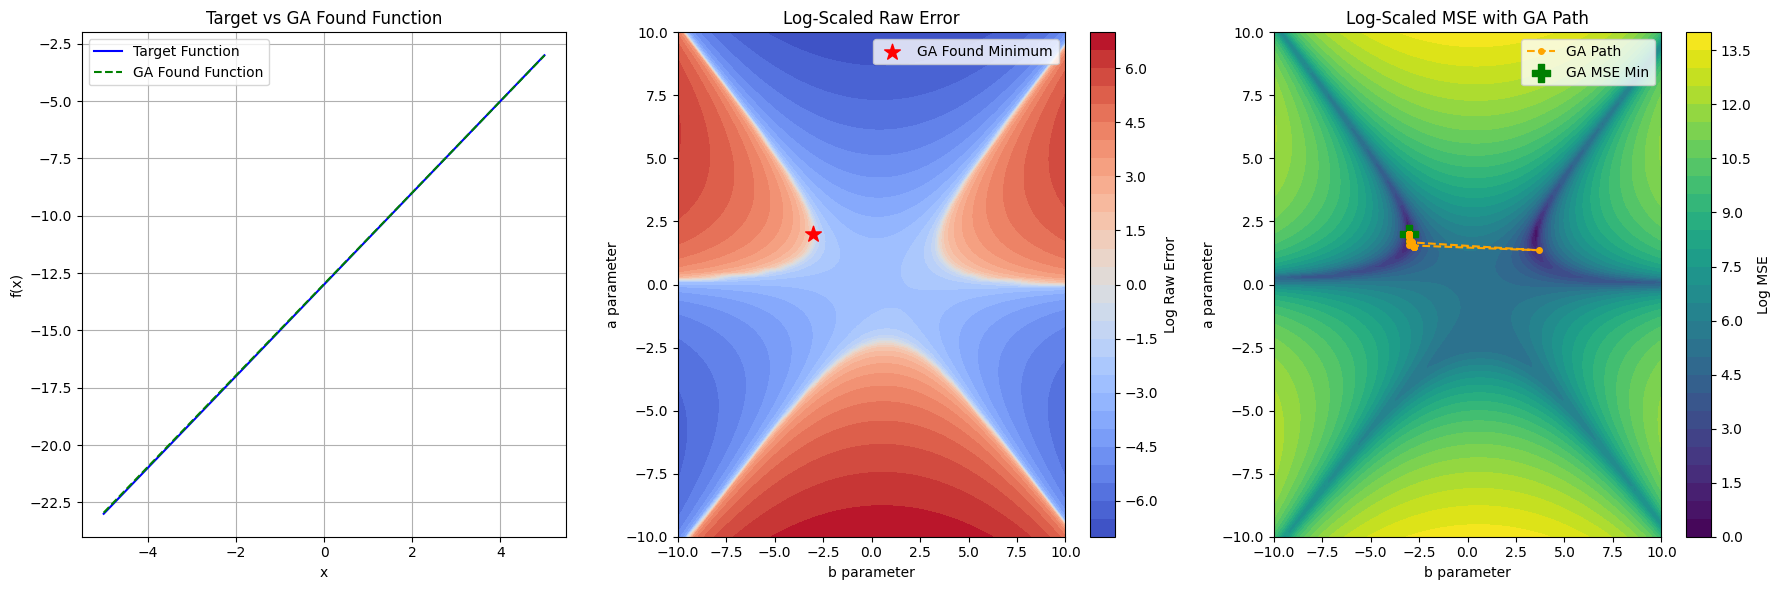

In [2]:
# Re-import necessary libraries after state reset
import numpy as np
import matplotlib.pyplot as plt

# Define search space and parameters
a_values = np.linspace(-10, 10, 100)
b_values = np.linspace(-10, 10, 100)
num_points = 100
x_range_1D = np.linspace(-5, 5, num_points)
epsilon = 1e-6

def linear_model(x, a, b):
    x = np.array(x)
    return a * np.sum(x) + b * a -b**2*a + a**3 - b

# Generate target function data
true_a, true_b = 2, -3  # True parameters for the target function

def target_function(x):
    return linear_model(x, true_a, true_b)

true_values_1D = np.array([target_function(x) for x in x_range_1D])

# Create MSE evaluation function
def mse_evaluation(a, b):
    predicted_values = np.array([linear_model(x, a, b) for x in x_range_1D])
    return np.mean((true_values_1D - predicted_values) ** 2)

# Genetic Algorithm for optimization
def genetic_algorithm_mse(pop_size=50, generations=100, mutation_rate=0.1):
    # Initialize random population of (a, b) pairs
    population = np.random.uniform(-10, 10, size=(pop_size, 2))
    history = []

    for gen in range(generations):
        # Evaluate fitness (lower MSE is better)
        fitness = np.array([mse_evaluation(a, b) for a, b in population])
        history.append(population[np.argmin(fitness)])  # Store best of this generation

        # Selection: Select the top 50% individuals
        sorted_indices = np.argsort(fitness)
        survivors = population[sorted_indices[:pop_size // 2]]

        # Crossover: Create offspring
        offspring = []
        for _ in range(pop_size // 2):
            parents = survivors[np.random.choice(len(survivors), 2, replace=False)]
            crossover_point = np.random.randint(1, 2)
            child = np.concatenate([parents[0][:crossover_point], parents[1][crossover_point:]])
            offspring.append(child)

        offspring = np.array(offspring)

        # Mutation: Apply random changes
        mutations = np.random.uniform(-1, 1, size=offspring.shape) * mutation_rate
        offspring += mutations

        # New population
        population = np.vstack((survivors, offspring))

    # Final evaluation
    final_fitness = np.array([mse_evaluation(a, b) for a, b in population])
    best_index = np.argmin(final_fitness)
    best_a, best_b = population[best_index]

    return best_a, best_b, np.array(history)

# Run genetic algorithm
a_ga_min, b_ga_min, ga_history = genetic_algorithm_mse()

# Plotting the result
# Generate MSE grid for visualization
error_grid = np.zeros((len(a_values), len(b_values)))
MSE_grid = np.zeros((len(a_values), len(b_values)))

for i, a in enumerate(a_values):
    for j, b in enumerate(b_values):
        predicted_values = np.array([linear_model(x, a, b) for x in x_range_1D])
        error_grid[i, j] = np.mean(true_values_1D - predicted_values)
        MSE_grid[i, j] = np.mean((true_values_1D - predicted_values) ** 2)

error_grid_log = np.sign(error_grid) * np.log1p(np.abs(error_grid) + epsilon)
MSE_grid_log = np.log1p(MSE_grid + epsilon)

# Plot GA path and results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Target function plot
axs[0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
# Plot found function using GA
found_values_1D = np.array([linear_model(x, a_ga_min, b_ga_min) for x in x_range_1D])
axs[0].plot(x_range_1D, found_values_1D, color='green', linestyle='--', label="GA Found Function")
axs[0].set_title("Target vs GA Found Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].grid(True)
axs[0].legend()

# Raw error contour plot
cmap1 = axs[1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")
axs[1].scatter(b_ga_min, a_ga_min, color="red", marker="*", s=140, label="GA Found Minimum")
axs[1].set_title("Log-Scaled Raw Error")
axs[1].set_xlabel("b parameter")
axs[1].set_ylabel("a parameter")
fig.colorbar(cmap1, ax=axs[1], label="Log Raw Error")
axs[1].legend(loc="upper right")

# MSE contour plot with GA path
cmap2 = axs[2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")
# Plot GA optimization path
ga_path_array = np.array(ga_history)
axs[2].plot(ga_path_array[:, 1], ga_path_array[:, 0], color="orange", linestyle="--", marker="o", markersize=4, label="GA Path")
# Mark the final solution
axs[2].scatter(b_ga_min, a_ga_min, color="green", marker="P", s=160, label="GA MSE Min")
axs[2].set_title("Log-Scaled MSE with GA Path")
axs[2].set_xlabel("b parameter")
axs[2].set_ylabel("a parameter")
fig.colorbar(cmap2, ax=axs[2], label="Log MSE")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()
